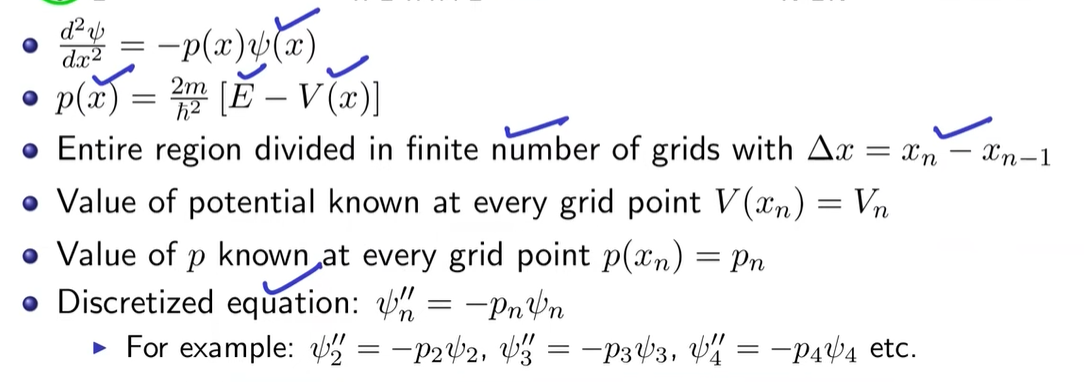
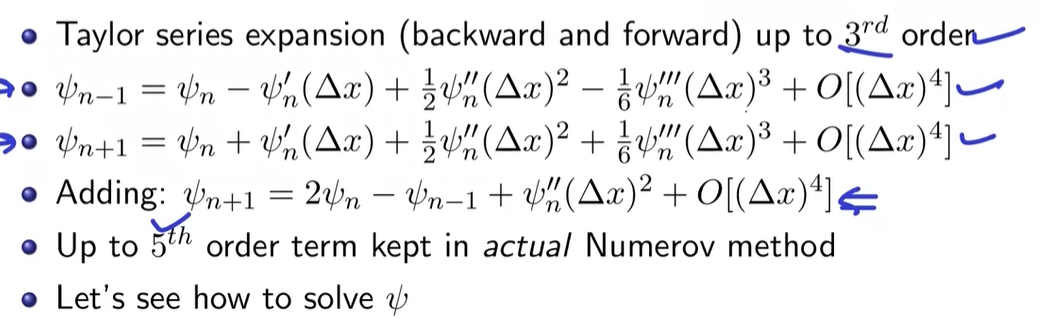

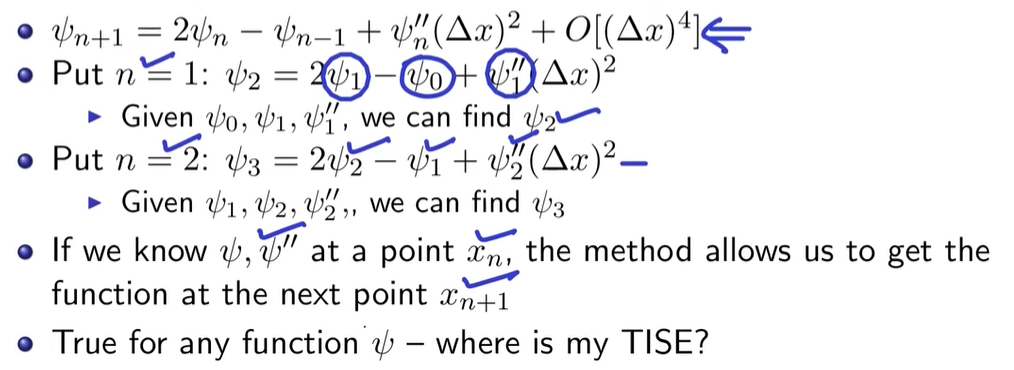

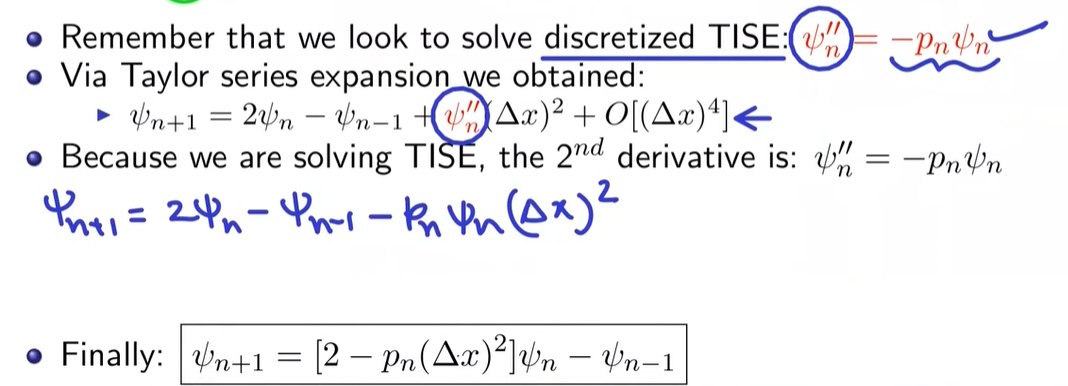

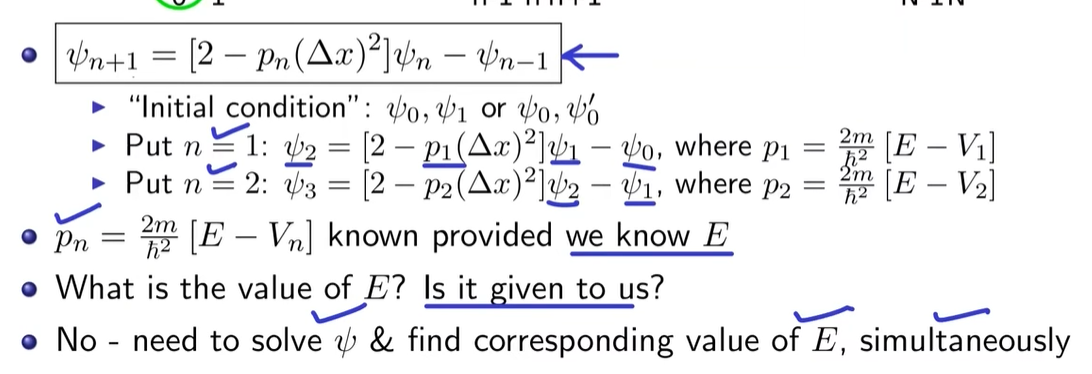

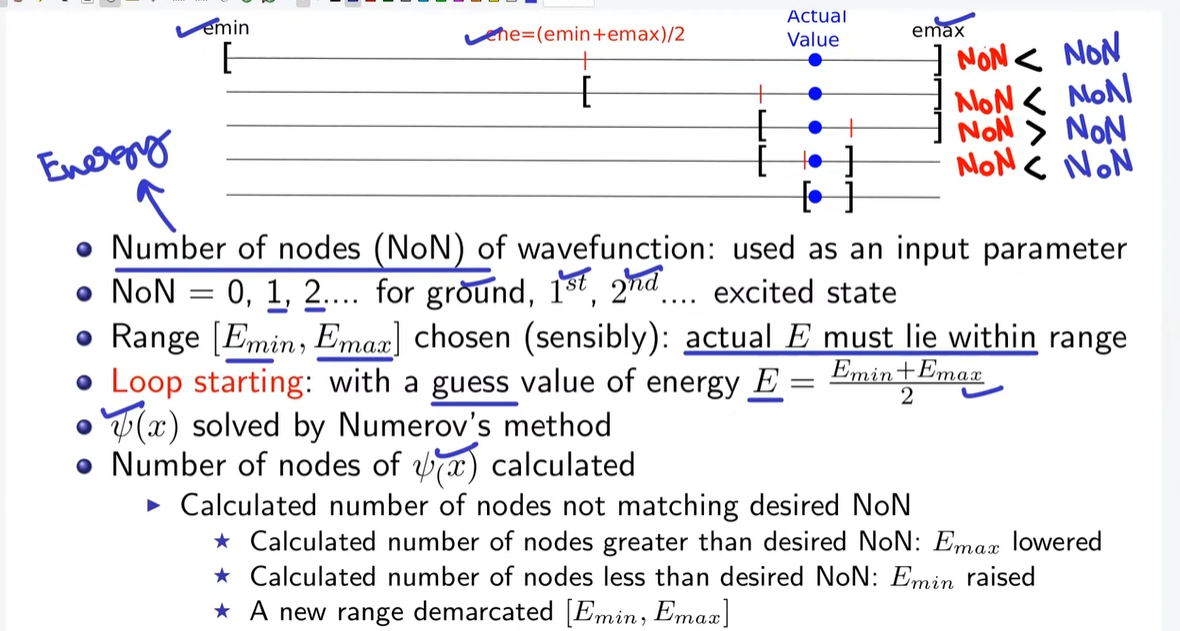
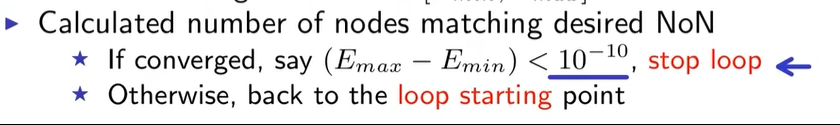

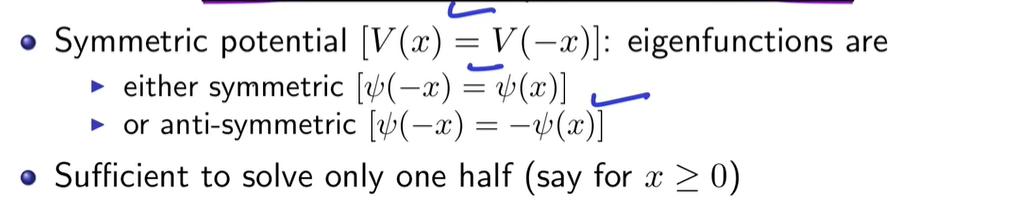

# Double well potential
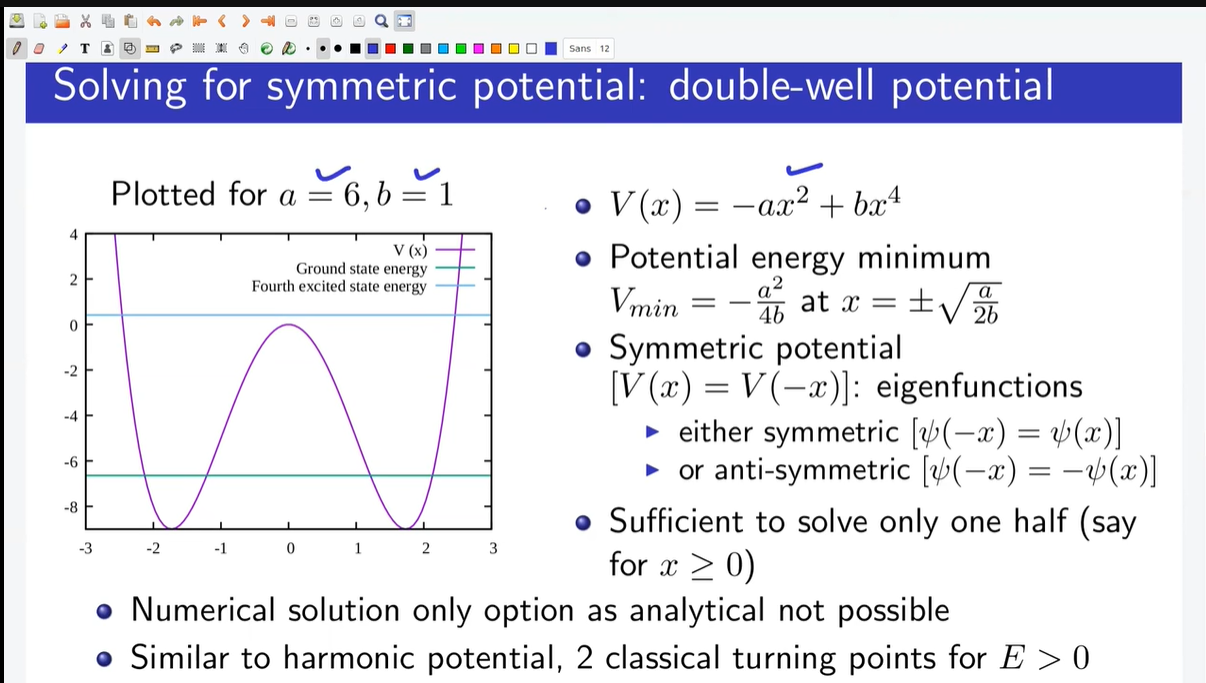

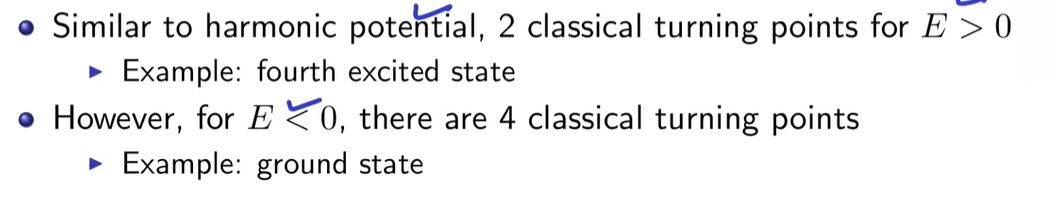

Energy eigenvalue for  0 th state is 0.49966672129152034


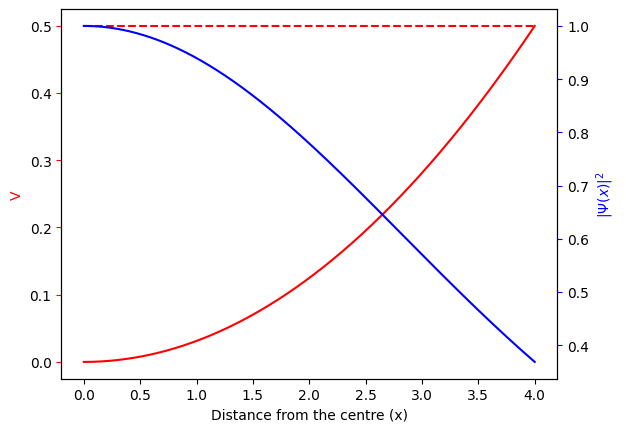

In [3]:
#Code for ODHO
import numpy as np
import matplotlib.pyplot as plt
nn=int(input("Enter the state:"))
nnn=nn/2 #because of symmetry
L= float(input("Enter the vlaue of L:"))
n=3000
dx=1/n
pe=np.zeros(n,float)
#f(x)=2.0*(E-0.5*x^2)
def fp(ene,x):
    value =2.0 * (ene - 0.5*x*x)
    return value

#harmonic potential
for i in range (n):
    x=i*dx
    pe[i]=0.5*x*x
emax = np.max(pe)
emin = np.min(pe)
psi=np.zeros(n,float)
#loop for energy convergence
while(emax-emin)>0.000000001:
    ene= (emax+emin)/2.0
    #first two points of wavefunction: symmeteric potential only
    if nn%2 == 1:
       psi[0]= 0.0
       psi[1]= dx
    else:
         psi[0]= 1.0
         psi[1]= 0.5 * (2.0-fp(ene,0)*dx*dx)*psi[0]
    #loop for wavefunction for given ene
    s=0
    for i in range (1,n-1):     
        x=i*dx
        psi[i+1]=(2.0- fp(ene,x)*dx*dx)*psi[i]-psi[i-1]
            #checking for nodes
        if np.sign(psi[i+1])!=np.sign(psi[i]):
            s+=1
    if s<=nnn:
        emax=emax
        emin=ene
    else:
        emax=ene
        emin=emin  
print('Energy eigenvalue for ',nn,'th state is',ene)
y =np.linspace(0,L,n)
fig,ax1=plt.subplots()
ax1.set_xlabel('Distance from the centre (x)')
ax1.set_ylabel('V',color='r')
ax1.tick_params(axis='y',color='r')
ax1.plot(y,pe,color='r')
ax1.hlines(ene,0,L,colors='r',linestyles='dashed')
ax2=ax1.twinx()
ax2.set_ylabel(r"$|\Psi(x)|^2$",color='b')
ax2.tick_params(axis='y',color='b')
ax2.plot(y,psi*psi,color='b')
plt.show()                      


Energy eigenvalue for 1th state (approx) is 1.500014325342
Node count on full line = 3 (target = 1), iterations = 34


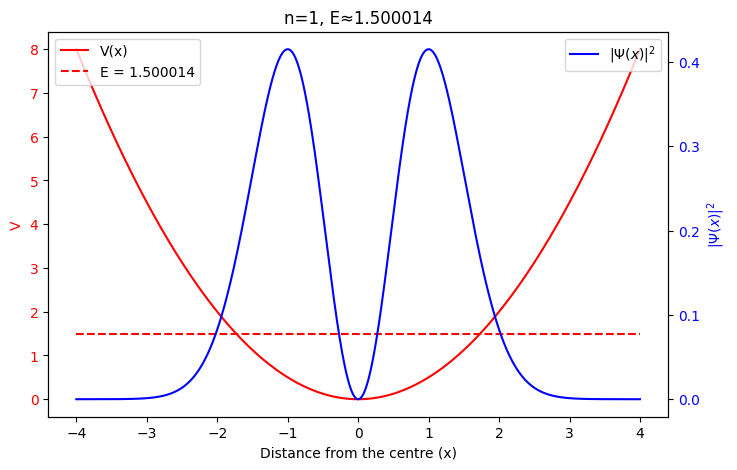

In [7]:
# Minimal-fixed ODHO code (keeps your original FD logic)
import numpy as np
import matplotlib.pyplot as plt

nn = int(input("Enter the state (ground=0, 1st excited=1): "))
L = float(input("Enter the value of L (half-domain, integrate 0..L): "))

n = 3000
# FIX: use L to set dx properly (was dx = 1/n)
dx = L / (n - 1)

# potential on half-domain 0..L
pe = np.zeros(n, float)
for i in range(n):
    x = i * dx
    pe[i] = 0.5 * x * x

# f(x) = 2*(E - V(x))
def fp(ene, x):
    return 2.0 * (ene - 0.5 * x * x)

# initial energy bracket: use potential min and some headroom above max
emin = np.min(pe)
emax = np.max(pe) + 5.0

psi = np.zeros(n, float)

def mirror_and_count_nodes(psi_half):
    """Mirror half-domain psi to full domain and count zero crossings."""
    # build full psi by reflecting half-domain (avoid duplicating center)
    psi_full = np.concatenate((psi_half[::-1], psi_half[1:]))
    # count sign changes excluding exact zeros
    nodes = 0
    for i in range(1, len(psi_full)):
        if psi_full[i-1] == 0.0:
            continue
        if np.sign(psi_full[i]) != np.sign(psi_full[i-1]):
            nodes += 1
    return nodes, psi_full

tol = 1e-9
max_iter = 500
it = 0

# main bisection loop (node-count shooting)
while (emax - emin) > tol and it < max_iter:
    ene = 0.5 * (emin + emax)

    # initial conditions at centre for symmetric potential:
    if nn % 2 == 1:
        # odd state: psi(0)=0, small slope -> set psi[1] = dx (arbitrary small)
        psi[0] = 0.0
        psi[1] = dx
    else:
        # even state: psi(0)!=0, choose psi(0)=1 and get psi(1) from FD recurrence
        psi[0] = 1.0
        psi[1] = 0.5 * (2.0 - fp(ene, 0.0) * dx * dx) * psi[0]

    # forward FD integration on half-domain
    for i in range(1, n-1):
        x = i * dx
        psi[i+1] = (2.0 - fp(ene, x) * dx * dx) * psi[i] - psi[i-1]

    # count nodes on full-line by mirroring half-domain psi
    nodes, psi_full_tmp = mirror_and_count_nodes(psi)

    # FIXED bisection logic:
    # If nodes <= target (nn) we need to raise lower bound; else lower upper bound.
    if nodes <= nn:
        emin = ene
    else:
        emax = ene

    it += 1

# final eigenvalue (midpoint)
E_final = 0.5 * (emin + emax)

# Recompute final psi at found energy (to avoid slight mismatch)
ene = E_final
if nn % 2 == 1:
    psi[0] = 0.0
    psi[1] = dx
else:
    psi[0] = 1.0
    psi[1] = 0.5 * (2.0 - fp(ene, 0.0) * dx * dx) * psi[0]

for i in range(1, n-1):
    x = i * dx
    psi[i+1] = (2.0 - fp(ene, x) * dx * dx) * psi[i] - psi[i-1]

nodes_final, psi_full = mirror_and_count_nodes(psi)

print(f"Energy eigenvalue for {nn}th state (approx) is {E_final:.12f}")
print(f"Node count on full line = {nodes_final} (target = {nn}), iterations = {it}")

# build full x array and normalize psi_full
x_full = np.linspace(-L, L, 2*n - 1)
norm = np.trapz(psi_full**2, x_full)
if norm > 0:
    psi_full = psi_full / np.sqrt(norm)

# plot potential and |psi|^2 on full domain
V_full = 0.5 * x_full**2
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(x_full, V_full, color='r', label='V(x)')
ax1.hlines(E_final, x_full[0], x_full[-1], colors='r', linestyles='dashed', label=f"E = {E_final:.6f}")
ax1.set_xlabel('Distance from the centre (x)')
ax1.set_ylabel('V', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(x_full, psi_full**2, color='b', label=r"$|\Psi(x)|^2$")
ax2.set_ylabel(r"$|\Psi(x)|^2$", color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title(f"n={nn}, E≈{E_final:.6f}")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


Energy eigenvalue for 2th state (approx) is 2.500200457725
Node count on full line = 4 (target = 2), iterations = 34


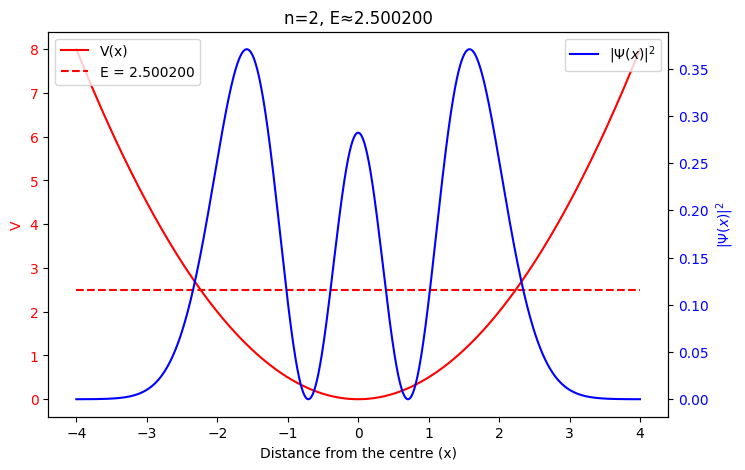

In [8]:
# Minimal-fixed ODHO code (keeps your original FD logic)
import numpy as np
import matplotlib.pyplot as plt

nn = int(input("Enter the state (ground=0, 1st excited=1): "))
L = float(input("Enter the value of L (half-domain, integrate 0..L): "))

n = 3000
# FIX: use L to set dx properly (was dx = 1/n)
dx = L / (n - 1)

# potential on half-domain 0..L
pe = np.zeros(n, float)
for i in range(n):
    x = i * dx
    pe[i] = 0.5 * x * x

# f(x) = 2*(E - V(x))
def fp(ene, x):
    return 2.0 * (ene - 0.5 * x * x)

# initial energy bracket: use potential min and some headroom above max
emin = np.min(pe)
emax = np.max(pe) + 5.0

psi = np.zeros(n, float)

def mirror_and_count_nodes(psi_half):
    """Mirror half-domain psi to full domain and count zero crossings."""
    # build full psi by reflecting half-domain (avoid duplicating center)
    psi_full = np.concatenate((psi_half[::-1], psi_half[1:]))
    # count sign changes excluding exact zeros
    nodes = 0
    for i in range(1, len(psi_full)):
        if psi_full[i-1] == 0.0:
            continue
        if np.sign(psi_full[i]) != np.sign(psi_full[i-1]):
            nodes += 1
    return nodes, psi_full

tol = 1e-9
max_iter = 500
it = 0

# main bisection loop (node-count shooting)
while (emax - emin) > tol and it < max_iter:
    ene = 0.5 * (emin + emax)

    # initial conditions at centre for symmetric potential:
    if nn % 2 == 1:
        # odd state: psi(0)=0, small slope -> set psi[1] = dx (arbitrary small)
        psi[0] = 0.0
        psi[1] = dx
    else:
        # even state: psi(0)!=0, choose psi(0)=1 and get psi(1) from FD recurrence
        psi[0] = 1.0
        psi[1] = 0.5 * (2.0 - fp(ene, 0.0) * dx * dx) * psi[0]

    # forward FD integration on half-domain
    for i in range(1, n-1):
        x = i * dx
        psi[i+1] = (2.0 - fp(ene, x) * dx * dx) * psi[i] - psi[i-1]

    # count nodes on full-line by mirroring half-domain psi
    nodes, psi_full_tmp = mirror_and_count_nodes(psi)

    # FIXED bisection logic:
    # If nodes <= target (nn) we need to raise lower bound; else lower upper bound.
    if nodes <= nn:
        emin = ene
    else:
        emax = ene

    it += 1

# final eigenvalue (midpoint)
E_final = 0.5 * (emin + emax)

# Recompute final psi at found energy (to avoid slight mismatch)
ene = E_final
if nn % 2 == 1:
    psi[0] = 0.0
    psi[1] = dx
else:
    psi[0] = 1.0
    psi[1] = 0.5 * (2.0 - fp(ene, 0.0) * dx * dx) * psi[0]

for i in range(1, n-1):
    x = i * dx
    psi[i+1] = (2.0 - fp(ene, x) * dx * dx) * psi[i] - psi[i-1]

nodes_final, psi_full = mirror_and_count_nodes(psi)

print(f"Energy eigenvalue for {nn}th state (approx) is {E_final:.12f}")
print(f"Node count on full line = {nodes_final} (target = {nn}), iterations = {it}")

# build full x array and normalize psi_full
x_full = np.linspace(-L, L, 2*n - 1)
norm = np.trapz(psi_full**2, x_full)
if norm > 0:
    psi_full = psi_full / np.sqrt(norm)

# plot potential and |psi|^2 on full domain
V_full = 0.5 * x_full**2
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(x_full, V_full, color='r', label='V(x)')
ax1.hlines(E_final, x_full[0], x_full[-1], colors='r', linestyles='dashed', label=f"E = {E_final:.6f}")
ax1.set_xlabel('Distance from the centre (x)')
ax1.set_ylabel('V', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(x_full, psi_full**2, color='b', label=r"$|\Psi(x)|^2$")
ax2.set_ylabel(r"$|\Psi(x)|^2$", color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title(f"n={nn}, E≈{E_final:.6f}")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


Energy for n=1 is E ≈ -6.640629133906


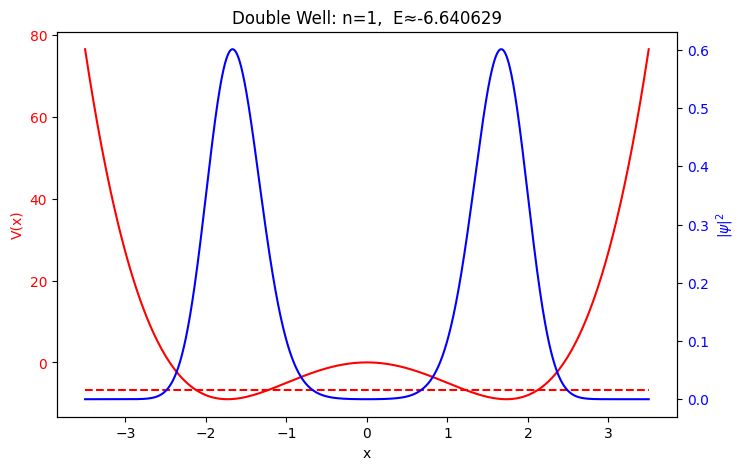

In [9]:
#Double potential well
import numpy as np
import matplotlib.pyplot as plt

# --- INPUTS ---
nn = int(input("Enter the number of nodes of the wavefunction (ground=0, 1st excited=1): "))
a = 6.0
b = 1.0

# symmetry still valid (potential is even)
L = float(input("Enter the value of L: "))

n = 3000
dx = L / (n - 1)

# --- BUILD POTENTIAL: V(x) = -a x^2 + b x^4 ---
pe = np.zeros(n, float)
for i in range(n):
    x = i * dx
    pe[i] = -a * x*x + b * x**4

# fp = 2(E – V)
def fp(ene, x):
    return 2.0 * (ene + a*x*x - b*x**4)

# energy bracket
emin = np.min(pe)
emax = np.max(pe) + 5.0

psi = np.zeros(n, float)

# --- MIRROR FOR FULL DOMAIN + NODE COUNT ---
def mirror_and_count_nodes(psi_half, parity_odd):
    if parity_odd:
        left = -psi_half[::-1]   # odd: sign flip
    else:
        left = psi_half[::-1]    # even: no flip
    psi_full = np.concatenate((left, psi_half[1:]))

    nodes = 0
    for i in range(1, len(psi_full)):
        if psi_full[i-1] == 0:
            continue
        if np.sign(psi_full[i]) != np.sign(psi_full[i-1]):
            nodes += 1
    return nodes, psi_full

# --- MAIN BISECTION LOOP ---
tol = 1e-9
max_iter = 500
it = 0

while (emax - emin) > tol and it < max_iter:
    ene = 0.5 * (emin + emax)

    # Initial conditions (parity)
    if nn % 2 == 1:  # odd state
        psi[0] = 0.0
        psi[1] = dx
    else:            # even state
        psi[0] = 1.0
        psi[1] = 0.5*(2.0 - fp(ene, 0)*dx*dx)*psi[0]

    # Integrate forward
    for i in range(1, n-1):
        x = i * dx
        psi[i+1] = (2.0 - fp(ene, x)*dx*dx) * psi[i] - psi[i-1]

    nodes, psi_full_tmp = mirror_and_count_nodes(psi, parity_odd=(nn%2==1))

    # bisection update
    if nodes <= nn:
        emin = ene
    else:
        emax = ene

    it += 1

# --- FINAL ENERGY ---
E_final = 0.5 * (emin + emax)

# recompute psi for final energy
ene = E_final
if nn % 2 == 1:
    psi[0] = 0.0
    psi[1] = dx
else:
    psi[0] = 1.0
    psi[1] = 0.5*(2.0 - fp(ene, 0)*dx*dx)*psi[0]

for i in range(1, n-1):
    x = i * dx
    psi[i+1] = (2.0 - fp(ene, x)*dx*dx) * psi[i] - psi[i-1]

nodes_final, psi_full = mirror_and_count_nodes(psi, parity_odd=(nn%2==1))

print(f"Energy for n={nn} is E ≈ {E_final:.12f}")

# normalize
x_full = np.linspace(-L, L, 2*n - 1)
norm = np.trapz(psi_full**2, x_full)
psi_full /= np.sqrt(norm)

# plotting
V_full = -a*x_full**2 + b*x_full**4

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(x_full, V_full, 'r', label='V(x)')
ax1.hlines(E_final, x_full[0], x_full[-1], colors='r', linestyles='dashed')
ax1.set_xlabel('x')
ax1.set_ylabel('V(x)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(x_full, psi_full**2, 'b', label=r"$|\psi|^2$")
ax2.set_ylabel(r"$|\psi|^2$", color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title(f"Double Well: n={nn},  E≈{E_final:.6f}")
plt.show()
